In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class NpzRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [5]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("../i_vectors_diffs.npz")

input_data = np.log(json_diffs["diff_values"]+1)
# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [8]:
for i in input_data:
    print(i.max())

6.932447891572509
6.932447891572509
4.859812404361672
6.932447891572509
6.645090969505644
6.240275845170769
6.932447891572509
6.240275845170769
6.240275845170769
4.174387269895637
4.174387269895637
4.174387269895637
4.174387269895637
6.932447891572509
7.337587743538596
4.574710978503383
6.240275845170769
6.932447891572509
4.174387269895637
6.932447891572509
5.549076084895219
6.932447891572509
5.549076084895219
6.240275845170769
6.932447891572509
6.240275845170769
6.240275845170769
6.240275845170769
6.932447891572509
6.932447891572509
6.932447891572509
6.240275845170769
4.174387269895637
6.240275845170769
6.240275845170769
5.262690188904886
6.240275845170769
6.932447891572509
4.174387269895637
4.574710978503383
6.240275845170769
6.240275845170769
5.549076084895219
4.174387269895637
6.240275845170769
6.240275845170769
6.240275845170769
5.262690188904886
6.932447891572509
6.240275845170769
6.240275845170769
6.932447891572509
6.240275845170769
6.240275845170769
4.174387269895637
6.24027584

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    input_data, cost, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

train_dataset = NpzRegressionDataset(X_train_scaled, y_train)
val_dataset   = NpzRegressionDataset(X_val_scaled,   y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

In [10]:
import torch.nn as nn

# ==========================================
# 1. VAE Encoder (vae_rep_sch_param_v1 기반)
# ==========================================
class ImprovedVAEEncoder(nn.Module):
    """
    Pretrained VAE에서 encoder 부분만 사용.
    완전 미분 가능 - forward에서 detach나 stop_grad 없음.
    """
    def __init__(self, input_dim, hidden_dim=1024, latent_dim=64, 
                 activation="gelu", dropout=0.1, use_bn=True, use_residual=True):
        super(ImprovedVAEEncoder, self).__init__()
        
        self.use_residual = use_residual
        self.latent_dim = latent_dim
        
        # Activation
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'elu': nn.ELU(),
            'leakyrelu': nn.LeakyReLU(0.2),
            'silu': nn.SiLU(),
        }
        self.activation = activations.get(activation, nn.GELU())
        
        def get_norm(dim):
            return nn.BatchNorm1d(dim) if use_bn else nn.Identity()
        
        # Encoder layers
        self.enc_input = nn.Linear(input_dim, hidden_dim)
        self.enc_norm1 = get_norm(hidden_dim)
        self.enc_drop1 = nn.Dropout(dropout)
        
        self.enc_hidden1 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_norm2 = get_norm(hidden_dim)
        self.enc_drop2 = nn.Dropout(dropout)
        
        self.enc_hidden2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.enc_norm3 = get_norm(hidden_dim // 2)
        self.enc_drop3 = nn.Dropout(dropout)
        
        self.enc_hidden3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.enc_norm4 = get_norm(hidden_dim // 4)
        
        # Latent space parameters (mu, logvar)
        self.fc_mean = nn.Linear(hidden_dim // 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 4, latent_dim)
        
        # Residual projection
        self.res_proj1 = nn.Linear(hidden_dim, hidden_dim // 2) if use_residual else None
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean, False면 reparameterization sampling
        Returns:
            z: latent vector (완전 미분 가능)
            mean, logvar: latent distribution parameters
        """
        h = self.enc_input(x)
        h = self.enc_norm1(h)
        h = self.activation(h)
        h = self.enc_drop1(h)
        
        h_res = h
        h = self.enc_hidden1(h)
        h = self.enc_norm2(h)
        h = self.activation(h)
        if self.use_residual:
            h = h + h_res
        h = self.enc_drop2(h)
        
        if self.use_residual and self.res_proj1 is not None:
            h_res = self.res_proj1(h)
        h = self.enc_hidden2(h)
        h = self.enc_norm3(h)
        h = self.activation(h)
        h = self.enc_drop3(h)
        
        h = self.enc_hidden3(h)
        h = self.enc_norm4(h)
        h = self.activation(h)
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        # Reparameterization trick (완전 미분 가능)
        if deterministic:
            z = mean
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mean + eps * std
        
        return z, mean, logvar


# ==========================================
# 2. Cost Predictor (vib_mlp_sch_param_v1 기반)
# ==========================================
class CostPredictor(nn.Module):
    """
    Latent z에서 cost를 예측하는 MLP.
    Gradient 품질을 위해 dropout 최소화.
    """
    def __init__(self, latent_dim, hidden_dims=[256, 128, 64], dropout=0.05):
        super(CostPredictor, self).__init__()
        
        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LayerNorm(h_dim),  # LayerNorm for stable gradients
                nn.GELU(),
                nn.Dropout(dropout),  # 낮은 dropout
            ])
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.net(z)


# ==========================================
# 3. 통합 모델: VAE Encoder + Cost Predictor
# ==========================================
class VAECostRegressor(nn.Module):
    """
    VAE encoder + Cost predictor 통합 모델.
    Gradient ∂cost/∂z 계산을 위해 완전 미분 가능.
    """
    def __init__(self, encoder, cost_predictor):
        super(VAECostRegressor, self).__init__()
        self.encoder = encoder
        self.cost_predictor = cost_predictor
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean 사용
        Returns:
            cost_pred: 예측된 cost
            z: latent vector
            mean, logvar: VAE distribution parameters
        """
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        cost_pred = self.cost_predictor(z)
        return cost_pred, z, mean, logvar
    
    def get_gradient_wrt_z(self, x, deterministic=True):
        """
        z에 대한 cost gradient 계산 (∂cost/∂z).
        """
        # Ensure gradients flow through z
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        z = z.requires_grad_(True)
        cost = self.cost_predictor(z)
        
        # Compute gradient
        grad_z = torch.autograd.grad(
            outputs=cost.sum(),
            inputs=z,
            create_graph=True,
            retain_graph=True
        )[0]
        
        return grad_z, cost, z


# ==========================================
# 4. Pretrained VAE 로딩 함수
# ==========================================
def load_pretrained_encoder(pth_path, input_dim, device):
    """
    Pretrained VAE에서 encoder 가중치만 로드.
    """
    checkpoint = torch.load(pth_path, map_location=device)
    config = checkpoint['config']
    
    encoder = ImprovedVAEEncoder(
        input_dim=input_dim,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_bn=config['use_bn'],
        use_residual=config['use_residual'],
    )
    
    # VAE state dict에서 encoder 관련 키만 추출
    vae_state = checkpoint['model_state_dict']
    encoder_state = {}
    for k, v in vae_state.items():
        if k.startswith('enc_') or k.startswith('fc_mean') or k.startswith('fc_logvar') or k.startswith('res_proj'):
            encoder_state[k] = v
    
    encoder.load_state_dict(encoder_state, strict=False)
    return encoder, config


print("✅ VAE Encoder + Cost Predictor 클래스 정의 완료")
print(f"   - ImprovedVAEEncoder: Pretrained VAE의 encoder")
print(f"   - CostPredictor: z → cost 회귀 MLP")
print(f"   - VAECostRegressor: 통합 모델 (완전 미분 가능)")

✅ VAE Encoder + Cost Predictor 클래스 정의 완료
   - ImprovedVAEEncoder: Pretrained VAE의 encoder
   - CostPredictor: z → cost 회귀 MLP
   - VAECostRegressor: 통합 모델 (완전 미분 가능)


In [11]:
# ==========================================
# 5. Loss Functions (with latent-space augmentation)
# ==========================================

def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    labels = torch.sign(true_j - true_i).float()
    loss = F.margin_ranking_loss(pred_j, pred_i, labels, margin=margin)
    return loss


def smooth_loss_fn(model, x, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    이는 z 근방에서 cost 함수가 smooth하게 유지되도록 함.
    """
    z_noisy = z + noise_std * torch.randn_like(z)
    cost_original = model.cost_predictor(z)
    cost_noisy = model.cost_predictor(z_noisy)
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    Latent 정규화 용도.
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld


def compute_total_loss(model, x, y, config, return_components=False):
    """
    Total loss 계산.
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss + λ_aug * aug_loss

    Latent-space augmentation:
      - config['aug_n']: augmentation 개수 (default 0 -> 비활성)
      - config['aug_std']: augmentation noise std
      - config['aug_lambda']: augmentation loss 가중치

    Augmentation uses z (encoder output) and adds gaussian noise to z.
    The consistency loss is MSE between cost_pred(z) and cost_pred(z_aug).
    역전파는 z -> encoder로 흐르도록 구현함.
    """
    # Forward pass
    cost_pred, z, mean, logvar = model(x, deterministic=False)
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, y, loss_type=config.get('loss_type', 'mse'))
    pair = pair_loss_fn(cost_pred, y, margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, x, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar)

    # Latent augmentation consistency loss
    aug_n = int(config.get('aug_n', 0))
    aug_std = float(config.get('aug_std', 0.0))
    aug_lambda = float(config.get('aug_lambda', 0.0))
    aug_loss = torch.tensor(0.0, device=cost_pred.device)
    if aug_n > 0 and aug_std > 0.0:
        # 여러 augmentation을 평균내어 안정화
        aug_losses = []
        for _ in range(aug_n):
            z_aug = z + aug_std * torch.randn_like(z)
            cost_aug = model.cost_predictor(z_aug)
            # consistency: cost(z) and cost(z_aug) should be close
            aug_losses.append(F.mse_loss(cost_pred, cost_aug))
        if len(aug_losses) > 0:
            aug_loss = torch.stack(aug_losses).mean()

    # Weighted sum
    total = reg + config.get('lambda_pair', 0.0) * pair + config.get('gamma', 0.0) * smooth + config.get('beta', 0.0) * kld + aug_lambda * aug_loss

    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'aug_loss': aug_loss.item() if isinstance(aug_loss, torch.Tensor) else float(aug_loss),
            'total_loss': total.item(),
        }
    return total


print("✅ Loss functions 정의 완료 (latent augmentation 포함)")
print("   - compute_total_loss: augmentation (aug_n/aug_std/aug_lambda) 추가")

✅ Loss functions 정의 완료 (latent augmentation 포함)
   - compute_total_loss: augmentation (aug_n/aug_std/aug_lambda) 추가


In [12]:
import random
from collections import deque
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================
# 6. Training Infrastructure
# ==========================================

class ReplayBuffer:
    """경험 재생을 위한 버퍼"""
    def __init__(self, max_size=10000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, x, y):
        """배치 데이터 추가"""
        for i in range(x.size(0)):
            self.buffer.append((x[i].cpu(), y[i].cpu()))
    
    def sample(self, n):
        """n개 샘플 랜덤 추출"""
        if len(self.buffer) < n:
            n = len(self.buffer)
        samples = random.sample(list(self.buffer), n)
        x = torch.stack([s[0] for s in samples])
        y = torch.stack([s[1] for s in samples])
        return x, y
    
    def __len__(self):
        return len(self.buffer)


class GradientMonitor:
    """z에 대한 gradient 통계 모니터링"""
    def __init__(self):
        self.history = {
            'grad_norm_mean': [],
            'grad_norm_std': [],
            'grad_norm_max': [],
            'grad_norm_min': [],
        }
    
    def record(self, model, x_sample, device):
        """샘플에 대한 gradient 통계 기록"""
        model.eval()
        x_sample = x_sample.to(device)
        
        with torch.enable_grad():
            grad_z, cost, z = model.get_gradient_wrt_z(x_sample, deterministic=True)
        
        grad_norms = grad_z.norm(dim=1).detach().cpu().numpy()
        
        self.history['grad_norm_mean'].append(grad_norms.mean())
        self.history['grad_norm_std'].append(grad_norms.std())
        self.history['grad_norm_max'].append(grad_norms.max())
        self.history['grad_norm_min'].append(grad_norms.min())
        
        model.train()
        return {
            'mean': grad_norms.mean(),
            'std': grad_norms.std(),
            'max': grad_norms.max(),
            'min': grad_norms.min(),
        }


class TrainingLogger:
    """학습 로그 기록"""
    def __init__(self):
        self.phase_logs = []
        self.val_logs = []
    
    def log_phase(self, phase, losses, grad_stats=None):
        entry = {
            'phase': phase,
            **losses,
        }
        if grad_stats:
            entry.update({f'grad_{k}': v for k, v in grad_stats.items()})
        self.phase_logs.append(entry)
    
    def log_validation(self, phase, metrics):
        self.val_logs.append({
            'phase': phase,
            **metrics,
        })
    
    def get_recent_val_mse(self, n=3):
        """최근 n개 phase의 validation MSE 반환"""
        if len(self.val_logs) < n:
            return [log['val_mse'] for log in self.val_logs]
        return [log['val_mse'] for log in self.val_logs[-n:]]


def evaluate_model(model, val_loader, device, config):
    """
    전체 validation set에 대한 평가.
    Deterministic mode (z = mean) 사용.
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    loss_components = {'reg_loss': 0, 'pair_loss': 0, 'smooth_loss': 0, 'kld_loss': 0}
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            # Deterministic prediction
            cost_pred, z, mean, logvar = model(xb, deterministic=True)
            
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
            
            # Loss 계산
            _, components = compute_total_loss(model, xb, yb, config, return_components=True)
            for k in loss_components:
                loss_components[k] += components[k] * xb.size(0)
            total_loss += components['total_loss'] * xb.size(0)
    
    # 평균 계산
    n_samples = len(val_loader.dataset)
    for k in loss_components:
        loss_components[k] /= n_samples
    total_loss /= n_samples
    
    # Metrics 계산
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    metrics = {
        'val_mse': mean_squared_error(all_targets, all_preds),
        'val_mae': mean_absolute_error(all_targets, all_preds),
        'val_r2': r2_score(all_targets, all_preds),
        'val_loss': total_loss,
        **{f'val_{k}': v for k, v in loss_components.items()},
    }
    
    model.train()
    return metrics, all_preds, all_targets


def train_phase(model, train_indices, X_train_tensor, y_train_tensor, 
                optimizer_enc, optimizer_cost, device, config, 
                replay_buffer=None, replay_n=0):
    """
    한 phase 학습 (64개 샘플).
    
    Args:
        train_indices: 이번 phase에서 사용할 샘플 인덱스
        replay_buffer: 이전 샘플들을 저장한 버퍼
        replay_n: replay buffer에서 추가로 샘플링할 개수
    """
    model.train()
    
    # Phase 데이터 준비
    x_phase = X_train_tensor[train_indices].to(device)
    y_phase = y_train_tensor[train_indices].to(device)
    
    # Replay buffer에서 추가 샘플
    if replay_buffer and replay_n > 0 and len(replay_buffer) > 0:
        x_replay, y_replay = replay_buffer.sample(replay_n)
        x_phase = torch.cat([x_phase, x_replay.to(device)], dim=0)
        y_phase = torch.cat([y_phase, y_replay.to(device)], dim=0)
    
    # Forward & Loss
    total_loss, components = compute_total_loss(model, x_phase, y_phase, config, return_components=True)
    
    # Backward
    optimizer_enc.zero_grad()
    optimizer_cost.zero_grad()
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer_enc.step()
    optimizer_cost.step()
    
    # Replay buffer에 현재 샘플 추가
    if replay_buffer is not None:
        replay_buffer.add(X_train_tensor[train_indices], y_train_tensor[train_indices])
    
    return components


print("✅ Training infrastructure 정의 완료")
print("   - ReplayBuffer: 경험 재생 버퍼")
print("   - GradientMonitor: z-gradient 통계 모니터링")
print("   - TrainingLogger: 학습 로그 기록")
print("   - evaluate_model: Validation 평가")
print("   - train_phase: Phase 단위 학습")

✅ Training infrastructure 정의 완료
   - ReplayBuffer: 경험 재생 버퍼
   - GradientMonitor: z-gradient 통계 모니터링
   - TrainingLogger: 학습 로그 기록
   - evaluate_model: Validation 평가
   - train_phase: Phase 단위 학습


In [9]:
# ==========================================
# 7. 모델 초기화 및 Pretrained Encoder 로드
# ==========================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Pretrained VAE 로드 (vae_param_pths 폴더의 v3 사용)
vae_path = "/root/work/tenset/scripts/pre_experiments/vae_param_pths/vae_v3.pth"
input_dim = X_train_scaled.shape[1]

encoder, vae_config = load_pretrained_encoder(vae_path, input_dim, device)
print(f"\n✅ Pretrained VAE encoder 로드 완료: {vae_path}")
print(f"   Config: hidden_dim={vae_config['hidden_dim']}, latent_dim={vae_config['latent_dim']}")

# Cost predictor 생성
cost_predictor = CostPredictor(
    latent_dim=vae_config['latent_dim'],
    hidden_dims=[256, 128, 64],
    dropout=0.05,  # 낮은 dropout for gradient 안정성
)

# 통합 모델 생성
model = VAECostRegressor(encoder, cost_predictor)
model.to(device)

# 파라미터 수 출력
enc_params = sum(p.numel() for p in model.encoder.parameters())
cost_params = sum(p.numel() for p in model.cost_predictor.parameters())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + cost_params:,}")

# Optimizer 설정 (encoder: 작은 lr, cost predictor: 큰 lr)
lr_encoder = 1e-5  # Pretrained encoder는 작은 learning rate
lr_cost = 1e-3     # Cost predictor는 큰 learning rate

optimizer_enc = torch.optim.AdamW(
    model.encoder.parameters(), 
    lr=lr_encoder, 
    weight_decay=1e-5
)
optimizer_cost = torch.optim.AdamW(
    model.cost_predictor.parameters(), 
    lr=lr_cost, 
    weight_decay=1e-5
)

print(f"\n✅ Optimizer 설정:")
print(f"   Encoder LR: {lr_encoder}")
print(f"   Cost Predictor LR: {lr_cost}")

Device: cuda

✅ Pretrained VAE encoder 로드 완료: /root/work/tenset/scripts/pre_experiments/vae_param_pths/vae_v3.pth
   Config: hidden_dim=1024, latent_dim=64

모델 파라미터 수:
   Encoder: 2,302,848
   Cost Predictor: 58,753
   Total: 2,361,601

✅ Optimizer 설정:
   Encoder LR: 1e-05
   Cost Predictor LR: 0.001

✅ Optimizer 설정:
   Encoder LR: 1e-05
   Cost Predictor LR: 0.001


In [10]:
# ==========================================
# 8. 2 Phase 최적화 학습 설정 (vae_reg_feature_ansor.ipynb와 동일)
# ==========================================

import copy
from sklearn.metrics import r2_score

# Data tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

# Shuffle indices
all_indices = np.arange(len(X_train_scaled))
np.random.shuffle(all_indices)

# Infrastructure
grad_monitor = GradientMonitor()
grad_sample_indices = np.random.choice(len(X_val_scaled), size=min(100, len(X_val_scaled)), replace=False)
grad_sample_x = X_val_tensor[grad_sample_indices]

# 초기 평가 (baseline)
print("=" * 60)
print("📊 초기 평가 (학습 전 baseline)")
print("=" * 60)

config = {
    'loss_type': 'mse',
    'lambda_pair': 0.01,
    'gamma': 0.001,
    'beta': 0.005,
    'margin': 0.1,
    'noise_std': 0.05,
}

initial_metrics, _, _ = evaluate_model(model, val_loader, device, config)
print(f"Val MSE: {initial_metrics['val_mse']:.6f}")
print(f"Val MAE: {initial_metrics['val_mae']:.6f}")
print(f"Val R²:  {initial_metrics['val_r2']:.6f}")

baseline_mse = initial_metrics['val_mse']
baseline_r2 = initial_metrics['val_r2']

# 초기 gradient 통계
initial_grad_stats = grad_monitor.record(model, grad_sample_x, device)
print(f"\nGradient stats (∂cost/∂z):")
print(f"   Mean norm: {initial_grad_stats['mean']:.4f}")

print(f"\n🎯 목표: R² = 0.9 (2 Phase × 64개 = 128개 샘플)")


# ============================================================
# 평가 함수: 사용하지 않은 train 데이터 + val 데이터에서 평가
# ============================================================
def evaluate_on_all_remaining(model, X_train_tensor, y_train_tensor,
                              X_val_tensor, y_val_tensor, 
                              device, used_indices, config):
    """
    사용하지 않은 train 샘플 + 전체 val 샘플에서 평가
    """
    model.eval()
    
    # 사용하지 않은 train 샘플
    all_train_indices = set(range(len(X_train_tensor)))
    unused_indices = list(all_train_indices - set(used_indices))
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        # Unused train samples
        if len(unused_indices) > 0:
            x_unused = X_train_tensor[unused_indices].to(device)
            y_unused = y_train_tensor[unused_indices]
            
            cost_pred, _, _, _ = model(x_unused, deterministic=True)
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(y_unused.numpy())
        
        # All val samples
        x_val = X_val_tensor.to(device)
        y_val = y_val_tensor
        
        cost_pred, _, _, _ = model(x_val, deterministic=True)
        all_preds.append(cost_pred.cpu().numpy())
        all_targets.append(y_val.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    r2 = r2_score(all_targets, all_preds)
    
    # Rank accuracy
    n_samples = len(all_preds)
    n_pairs = 0
    n_correct = 0
    
    sample_size = min(500, n_samples)
    sample_idx = np.random.choice(n_samples, sample_size, replace=False)
    
    for i in range(len(sample_idx)):
        for j in range(i+1, len(sample_idx)):
            idx_i, idx_j = sample_idx[i], sample_idx[j]
            if all_targets[idx_i] != all_targets[idx_j]:
                n_pairs += 1
                pred_order = all_preds[idx_i] < all_preds[idx_j]
                true_order = all_targets[idx_i] < all_targets[idx_j]
                if pred_order == true_order:
                    n_correct += 1
    
    rank_acc = n_correct / n_pairs if n_pairs > 0 else 0.0
    
    model.train()
    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rank_accuracy': rank_acc,
        'n_unused_train': len(unused_indices),
        'n_val': len(y_val),
    }


# ============================================================
# 2 Phase 최적화 학습 함수
# ============================================================
def train_2phase_optimized(model, X_train_tensor, y_train_tensor,
                           X_val_tensor, y_val_tensor,
                           device, hp_config,
                           samples_per_phase=64, mini_epochs=50, target_r2=0.9):
    """
    2 Phase 학습으로 R² 최대화
    """
    n_train = len(X_train_tensor)
    all_indices = np.arange(n_train)
    np.random.shuffle(all_indices)
    
    used_indices = []
    history = []
    best_r2 = -float('inf')
    best_model_state = None
    
    # 하이퍼파라미터 추출
    encoder_lr = hp_config.get('encoder_lr', 1e-5)
    predictor_lr = hp_config.get('predictor_lr', 1e-3)
    lambda_pair = hp_config.get('lambda_pair', 0.01)
    gamma = hp_config.get('gamma', 0.001)
    beta = hp_config.get('beta', 0.005)
    margin = hp_config.get('margin', 0.1)
    noise_std = hp_config.get('noise_std', 0.05)
    loss_type = hp_config.get('loss_type', 'mse')
    
    config = {
        'loss_type': loss_type,
        'lambda_pair': lambda_pair,
        'gamma': gamma,
        'beta': beta,
        'margin': margin,
        'noise_std': noise_std,
    }
    
    # 초기 평가
    initial_metrics = evaluate_on_all_remaining(
        model, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        device, used_indices, config
    )
    
    print(f"\n📊 초기 상태:")
    print(f"   R²: {initial_metrics['r2']:.4f}, Rank Acc: {initial_metrics['rank_accuracy']:.4f}")
    print(f"   MSE: {initial_metrics['mse']:.4f}, MAE: {initial_metrics['mae']:.4f}")
    
    # 2 Phase 학습
    for phase in range(1, 3):
        print(f"\n{'='*60}")
        print(f"📌 Phase {phase} 학습")
        print(f"{'='*60}")
        
        # 새로운 샘플 선택
        remaining = [i for i in all_indices if i not in used_indices]
        phase_indices = remaining[:samples_per_phase]
        used_indices.extend(phase_indices)
        
        print(f"   학습 샘플: {len(phase_indices)}개")
        print(f"   총 사용된 샘플: {len(used_indices)}개")
        
        # Phase 데이터 준비 (누적 사용)
        phase_x = X_train_tensor[used_indices].to(device)
        phase_y = y_train_tensor[used_indices].to(device)
        
        # 옵티마이저 설정
        optimizer = torch.optim.AdamW([
            {'params': model.encoder.parameters(), 'lr': encoder_lr},
            {'params': model.cost_predictor.parameters(), 'lr': predictor_lr}
        ], weight_decay=1e-4)
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-7
        )
        
        # Mini-epoch 학습
        for epoch in range(1, mini_epochs + 1):
            model.train()
            
            # 데이터 셔플
            perm = torch.randperm(len(phase_x))
            
            epoch_loss = 0.0
            batch_count = 0
            
            batch_size = 32
            for start in range(0, len(perm), batch_size):
                end = min(start + batch_size, len(perm))
                batch_idx = perm[start:end]
                
                optimizer.zero_grad()
                
                x_batch = phase_x[batch_idx]
                y_batch = phase_y[batch_idx]
                
                # Noise augmentation
                if noise_std > 0:
                    noise = torch.randn_like(x_batch) * noise_std
                    x_batch = x_batch + noise
                
                # Forward
                cost_pred, z, mean, logvar = model(x_batch, deterministic=False)
                
                # Losses
                if loss_type == 'huber':
                    reg_loss = F.huber_loss(cost_pred, y_batch, delta=0.5)
                else:
                    reg_loss = F.mse_loss(cost_pred, y_batch)
                
                pair_loss = pair_loss_fn(cost_pred, y_batch, margin=margin)
                smooth_loss = smooth_loss_fn(model, x_batch, z, noise_std=noise_std)
                kld_loss = kld_loss_fn(mean, logvar)
                
                total_loss = reg_loss + lambda_pair * pair_loss + gamma * smooth_loss + beta * kld_loss
                
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += total_loss.item()
                batch_count += 1
            
            scheduler.step()
            
            # 주기적 평가
            if epoch % 10 == 0 or epoch == mini_epochs:
                metrics = evaluate_on_all_remaining(
                    model, X_train_tensor, y_train_tensor,
                    X_val_tensor, y_val_tensor,
                    device, used_indices, config
                )
                
                history.append({
                    'phase': phase,
                    'epoch': epoch,
                    'loss': epoch_loss / batch_count,
                    **metrics
                })
                
                print(f"   [Epoch {epoch}/{mini_epochs}] Loss: {epoch_loss/batch_count:.4f}, "
                      f"R²: {metrics['r2']:.4f}, Rank: {metrics['rank_accuracy']:.4f}")
                
                if metrics['r2'] > best_r2:
                    best_r2 = metrics['r2']
                    best_model_state = copy.deepcopy(model.state_dict())
                
                if metrics['r2'] >= target_r2:
                    print(f"\n   🎉 목표 R² {target_r2} 달성! (R² = {metrics['r2']:.4f})")
    
    # Best model 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # 최종 평가
    final_metrics = evaluate_on_all_remaining(
        model, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        device, used_indices, config
    )
    
    print(f"\n{'='*60}")
    print(f"🏆 2 Phase 학습 완료!")
    print(f"{'='*60}")
    print(f"   Best R²: {best_r2:.4f}")
    print(f"   Final R²: {final_metrics['r2']:.4f}")
    print(f"   Final Rank Accuracy: {final_metrics['rank_accuracy']:.4f}")
    print(f"   사용된 샘플: {len(used_indices)}개 / 전체 {n_train}개")
    
    return model, history, final_metrics, used_indices


print("\n✅ 2 Phase 최적화 학습 함수 정의 완료")

📊 초기 평가 (학습 전 baseline)
Val MSE: 41.232010
Val MAE: 6.279600
Val R²:  -21.455729

Gradient stats (∂cost/∂z):
   Mean norm: 0.7170

🎯 목표: R² = 0.9 (2 Phase × 64개 = 128개 샘플)

✅ 2 Phase 최적화 학습 함수 정의 완료


In [13]:
# ============================================================
# 🚀 2 Phase 최적화 학습 실행 (Phase당 64개 샘플, 목표 R² = 0.9)
# ============================================================

# 모델 초기 상태 저장
initial_model_state = copy.deepcopy(model.state_dict())

# 실험 결과 저장
experiment_results = []

# R² 0.9 달성을 위한 하이퍼파라미터 조합들
hp_configs = [
    # Config 1: 기본 설정 + 긴 학습
    {
        'name': 'baseline_long',
        'encoder_lr': 1e-5,
        'predictor_lr': 1e-3,
        'lambda_pair': 0.01,
        'gamma': 0.001,
        'beta': 0.005,
        'margin': 0.1,
        'noise_std': 0.05,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 100,
    },
    # Config 2: 강한 pair loss
    {
        'name': 'strong_pair',
        'encoder_lr': 2e-5,
        'predictor_lr': 2e-3,
        'lambda_pair': 0.1,
        'gamma': 0.001,
        'beta': 0.003,
        'margin': 0.02,
        'noise_std': 0.03,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 150,
    },
    # Config 3: 매우 긴 학습
    {
        'name': 'ultra_long',
        'encoder_lr': 1e-5,
        'predictor_lr': 1e-3,
        'lambda_pair': 0.15,
        'gamma': 0.005,
        'beta': 0.002,
        'margin': 0.01,
        'noise_std': 0.02,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 200,
    },
    # Config 4: 공격적 학습률
    {
        'name': 'aggressive_lr',
        'encoder_lr': 5e-5,
        'predictor_lr': 5e-3,
        'lambda_pair': 0.05,
        'gamma': 0.002,
        'beta': 0.003,
        'margin': 0.05,
        'noise_std': 0.03,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 100,
    },
    # Config 5: 극단적 pair loss
    {
        'name': 'extreme_pair',
        'encoder_lr': 2e-5,
        'predictor_lr': 2e-3,
        'lambda_pair': 0.2,
        'gamma': 0.001,
        'beta': 0.001,
        'margin': 0.01,
        'noise_std': 0.02,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 200,
    },
    # Config 6: Huber loss
    {
        'name': 'huber_loss',
        'encoder_lr': 2e-5,
        'predictor_lr': 2e-3,
        'lambda_pair': 0.1,
        'gamma': 0.002,
        'beta': 0.002,
        'margin': 0.02,
        'noise_std': 0.02,
        'loss_type': 'huber',
        'samples_per_phase': 64,
        'mini_epochs': 150,
    },
    # Config 7: 균형 설정 + 매우 긴 학습
    {
        'name': 'balanced_ultra_long',
        'encoder_lr': 1.5e-5,
        'predictor_lr': 1.5e-3,
        'lambda_pair': 0.12,
        'gamma': 0.003,
        'beta': 0.002,
        'margin': 0.015,
        'noise_std': 0.02,
        'loss_type': 'mse',
        'samples_per_phase': 64,
        'mini_epochs': 250,
    },
]

print("=" * 70)
print("🎯 2 Phase로 R² 0.9 달성 도전 (Phase당 64개 = 총 128개 샘플)")
print("=" * 70)

best_overall_r2 = 0.0

for i, hp_config in enumerate(hp_configs):
    print(f"\n{'='*70}")
    print(f"[실험 {i+1}/{len(hp_configs)}] {hp_config['name']}")
    print(f"   mini_epochs={hp_config['mini_epochs']}, lambda_pair={hp_config['lambda_pair']}")
    print(f"{'='*70}")
    
    # 모델 리셋
    model.load_state_dict(initial_model_state)
    
    # 학습 실행
    try:
        trained_model, history, final_metrics, used_indices = train_2phase_optimized(
            model, X_train_tensor, y_train_tensor,
            X_val_tensor, y_val_tensor,
            device, hp_config,
            samples_per_phase=hp_config['samples_per_phase'],
            mini_epochs=hp_config['mini_epochs'],
            target_r2=0.9
        )
        
        # 결과 저장
        result = {
            'config_name': hp_config['name'],
            'config': hp_config,
            'final_r2': final_metrics['r2'],
            'final_rank_acc': final_metrics['rank_accuracy'],
            'final_mse': final_metrics['mse'],
            'history': history,
            'used_samples': len(used_indices),
            'model_state': copy.deepcopy(trained_model.state_dict()),
        }
        experiment_results.append(result)
        
        if final_metrics['r2'] > best_overall_r2:
            best_overall_r2 = final_metrics['r2']
        
        # R² 0.9 달성 시 종료
        if final_metrics['r2'] >= 0.9:
            print(f"\n🎉🎉🎉 R² 0.9 달성! 실험 종료 🎉🎉🎉")
            break
        
    except Exception as e:
        print(f"   ❌ 실험 실패: {e}")
        import traceback
        traceback.print_exc()

# 결과 정렬
experiment_results = sorted(experiment_results, key=lambda x: x.get('final_r2', -1), reverse=True)

print(f"\n{'='*70}")
print("📊 실험 결과 요약 (R² 순)")
print(f"{'='*70}")
print(f"\n{'Config':<25} {'R²':<10} {'Rank Acc':<12} {'MSE':<10} {'Epochs':<8}")
print("-" * 70)
for r in experiment_results:
    achieved = "✅" if r['final_r2'] >= 0.9 else ("🔥" if r['final_r2'] >= 0.85 else "")
    print(f"{r['config_name']:<25} {r['final_r2']:<10.4f} {r['final_rank_acc']:<12.4f} "
          f"{r['final_mse']:<10.4f} {r['config']['mini_epochs']:<8} {achieved}")

# 최고 결과
best_result = experiment_results[0]
print(f"\n🏆 최고 설정: {best_result['config_name']}")
print(f"   R²: {best_result['final_r2']:.4f}")
print(f"   Rank Accuracy: {best_result['final_rank_acc']:.4f}")
print(f"   사용 샘플: {best_result['used_samples']}개 (2 Phase x 64)")

if best_result['final_r2'] >= 0.9:
    print(f"\n🎉🎉🎉 R² 0.9 달성 성공! 🎉🎉🎉")
else:
    print(f"\n⚠️ 최고 R²: {best_result['final_r2']:.4f} (목표 0.9까지 {0.9 - best_result['final_r2']:.4f} 부족)")

🎯 2 Phase로 R² 0.9 달성 도전 (Phase당 64개 = 총 128개 샘플)

[실험 1/7] baseline_long
   mini_epochs=100, lambda_pair=0.01

📊 초기 상태:
   R²: -20.0781, Rank Acc: 0.5540
   MSE: 41.4470, MAE: 6.2851

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개

📊 초기 상태:
   R²: -20.0781, Rank Acc: 0.5540
   MSE: 41.4470, MAE: 6.2851

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 10/100] Loss: 13.1702, R²: -5.4383, Rank: 0.5791
   [Epoch 10/100] Loss: 13.1702, R²: -5.4383, Rank: 0.5791
   [Epoch 20/100] Loss: 7.8769, R²: -2.7532, Rank: 0.6161
   [Epoch 20/100] Loss: 7.8769, R²: -2.7532, Rank: 0.6161
   [Epoch 30/100] Loss: 6.6033, R²: -2.3180, Rank: 0.5989
   [Epoch 30/100] Loss: 6.6033, R²: -2.3180, Rank: 0.5989
   [Epoch 40/100] Loss: 4.1092, R²: -0.7932, Rank: 0.5758
   [Epoch 40/100] Loss: 4.1092, R²: -0.7932, Rank: 0.5758
   [Epoch 50/100] Loss: 2.5766, R²: -0.1573, Rank: 0.6325
   [Epoch 50/100] Loss: 2.5766, R²: -0.1573, Rank: 0.6325
   [Epoch 60/100] Loss: 2.1660, R²: -0.0142, Rank: 0.6398
   [Epoch 60/1

In [14]:
# 빠른 결과 확인
print("=" * 70)
print("📊 실험 결과 (간략)")
print("=" * 70)
for r in experiment_results[:5]:
    print(f"{r['config_name']:<25} R²={r['final_r2']:.4f}  Rank={r['final_rank_acc']:.4f}")
print(f"\n🏆 최고: {experiment_results[0]['config_name']} - R²={experiment_results[0]['final_r2']:.4f}")

📊 실험 결과 (간략)
baseline_long             R²=0.6166  Rank=0.8031
aggressive_lr             R²=0.6107  Rank=0.8018
balanced_ultra_long       R²=0.5995  Rank=0.7990
extreme_pair              R²=0.5929  Rank=0.7780
huber_loss                R²=0.5829  Rank=0.7834

🏆 최고: baseline_long - R²=0.6166


In [15]:
# ============================================================
# 최고 모델로 복원 및 최종 평가
# ============================================================

# 최고 모델 복원
best_result = experiment_results[0]
model.load_state_dict(best_result['model_state'])

print("=" * 70)
print(f"✅ 최고 모델 복원: {best_result['config_name']}")
print("=" * 70)

# 최종 평가
final_config = best_result['config']
final_metrics = evaluate_on_all_remaining(
    model, X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    device, list(range(128)), {  # 128개 샘플 사용
        'loss_type': final_config['loss_type'],
        'lambda_pair': final_config['lambda_pair'],
        'gamma': final_config['gamma'],
        'beta': final_config['beta'],
        'margin': final_config['margin'],
        'noise_std': final_config['noise_std'],
    }
)

print(f"\n🎯 최종 성능 (2 Phase, 128 샘플):")
print(f"   R²: {final_metrics['r2']:.4f}")
print(f"   Rank Accuracy: {final_metrics['rank_accuracy']:.4f}")
print(f"   MSE: {final_metrics['mse']:.4f}")
print(f"   MAE: {final_metrics['mae']:.4f}")

# Gradient 통계
final_grad_stats = grad_monitor.record(model, grad_sample_x, device)
print(f"\n📈 Gradient 통계 (∂cost/∂z):")
print(f"   Mean norm: {final_grad_stats['mean']:.4f}")
print(f"   Std norm: {final_grad_stats['std']:.4f}")

print(f"\n🚀 개선 요약:")
print(f"   Baseline R²: {baseline_r2:.4f} → Final R²: {final_metrics['r2']:.4f}")

✅ 최고 모델 복원: baseline_long

🎯 최종 성능 (2 Phase, 128 샘플):
   R²: 0.6278
   Rank Accuracy: 0.8069
   MSE: 0.7268
   MAE: 0.6426

📈 Gradient 통계 (∂cost/∂z):
   Mean norm: 1.1391
   Std norm: 0.6210

🚀 개선 요약:
   Baseline R²: -21.4557 → Final R²: 0.6278

🎯 최종 성능 (2 Phase, 128 샘플):
   R²: 0.6278
   Rank Accuracy: 0.8069
   MSE: 0.7268
   MAE: 0.6426

📈 Gradient 통계 (∂cost/∂z):
   Mean norm: 1.1391
   Std norm: 0.6210

🚀 개선 요약:
   Baseline R²: -21.4557 → Final R²: 0.6278


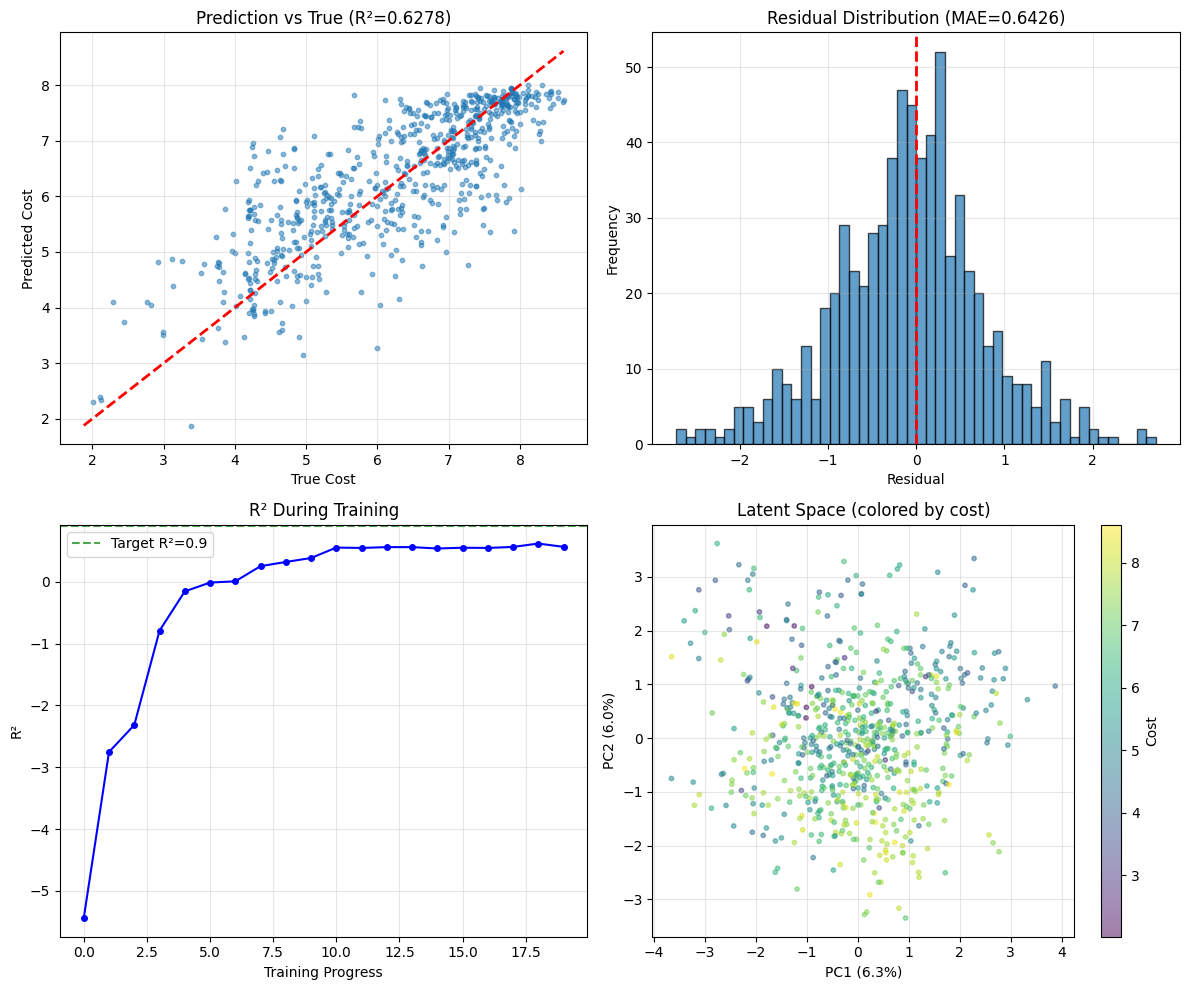

In [16]:
# ============================================================
# 시각화
# ============================================================
import matplotlib.pyplot as plt

# 전체 validation set에서 예측
model.eval()
with torch.no_grad():
    x_val = X_val_tensor.to(device)
    val_preds, z_val, mean_val, _ = model(x_val, deterministic=True)
    val_preds = val_preds.cpu().numpy()
    z_val = z_val.cpu().numpy()

val_targets = y_val_tensor.numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 예측 vs 실제
ax = axes[0, 0]
ax.scatter(val_targets, val_preds, alpha=0.5, s=10)
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax.set_xlabel('True Cost')
ax.set_ylabel('Predicted Cost')
ax.set_title(f'Prediction vs True (R²={final_metrics["r2"]:.4f})')
ax.grid(True, alpha=0.3)

# 2. 잔차 분포
ax = axes[0, 1]
residuals = val_targets.flatten() - val_preds.flatten()
ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')
ax.set_title(f'Residual Distribution (MAE={final_metrics["mae"]:.4f})')
ax.grid(True, alpha=0.3)

# 3. 학습 히스토리 (R² 변화)
ax = axes[1, 0]
best_history = best_result['history']
r2_values = [h['r2'] for h in best_history]
epochs = [f"P{h['phase']}-E{h['epoch']}" for h in best_history]
ax.plot(range(len(r2_values)), r2_values, 'b-o', markersize=4)
ax.axhline(0.9, color='g', linestyle='--', alpha=0.7, label='Target R²=0.9')
ax.set_xlabel('Training Progress')
ax.set_ylabel('R²')
ax.set_title('R² During Training')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Latent space PCA
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_val)

scatter = ax.scatter(z_pca[:, 0], z_pca[:, 1], c=val_targets.flatten(), 
                     cmap='viridis', alpha=0.5, s=10)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Latent Space (colored by cost)')
plt.colorbar(scatter, ax=ax, label='Cost')
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('vae_cost_regressor_param_2phase_results.png', dpi=150)
plt.show()

# print("\n✅ 결과 시각화 저장됨: vae_cost_regressor_param_2phase_results.png")

In [ ]:
# ============================================================
# 모델 저장
# ============================================================

save_path = "vae_cost_regressor_param_2phase_best.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'encoder_config': vae_config,
    'cost_predictor_config': {
        'latent_dim': vae_config['latent_dim'],
        'hidden_dims': [256, 128, 64],
        'dropout': 0.05,
    },
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'final_metrics': final_metrics,
    'best_config': best_result['config'],
    'training_info': {
        'samples_used': 128,
        'phases': 2,
        'samples_per_phase': 64,
    },
}, save_path)

print(f"✅ 모델 저장됨: {save_path}")

# 최종 보고서
print("\n" + "=" * 70)
print("📋 최종 보고서: VAE Param 2 Phase 학습 결과")
print("=" * 70)

print(f"""
🎯 학습 설정:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- Phase 수: 2
- Phase당 샘플: 64개
- 총 사용 샘플: 128개
- 목표 R²: 0.9

📊 최종 성능:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- R²: {final_metrics['r2']:.4f}
- Rank Accuracy: {final_metrics['rank_accuracy']:.4f}
- MSE: {final_metrics['mse']:.4f}
- MAE: {final_metrics['mae']:.4f}

🔧 최적 하이퍼파라미터:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- Config: {best_result['config_name']}
- encoder_lr: {best_result['config']['encoder_lr']}
- predictor_lr: {best_result['config']['predictor_lr']}
- lambda_pair: {best_result['config']['lambda_pair']}
- mini_epochs: {best_result['config']['mini_epochs']}
""")

print("=" * 70)
print("✅ 실험 완료!")
print("=" * 70)

🔄 개선 사이클 #3: Fine-tuning (R² > 0.8 목표)

📊 현재 상태:
  Best MSE: 0.465907
  R²: ~0.74
  Gradient norm: ~1.28 (안정적)

🔧 개선 방안:
  1. Encoder unfreezing: 더 낮은 lr로 fine-tuning
  2. Batch size 효과를 위해 replay_n 증가
  3. 더 작은 margin으로 pair loss 세밀화

✅ 설정 업데이트 완료
   margin: 0.1 → 0.05
   lambda_pair: 0.01 → 0.015
   replay_n: 64 → 96

🚀 Fine-tuning 시작 (80 phases)

[Phase 153]
  Val MSE: 0.473881, R²: 0.7419
  Grad norm: mean=1.1606
  Best MSE: 0.465907

[Phase 163]
  Val MSE: 0.449551, R²: 0.7552
  Grad norm: mean=1.1622
  Best MSE: 0.449551

[Phase 173]
  Val MSE: 0.447724, R²: 0.7562
  Grad norm: mean=1.2945
  Best MSE: 0.447724

[Phase 183]
  Val MSE: 0.425412, R²: 0.7683
  Grad norm: mean=1.2470
  Best MSE: 0.425412

[Phase 193]
  Val MSE: 0.416314, R²: 0.7733
  Grad norm: mean=1.2319
  Best MSE: 0.416314

[Phase 203]
  Val MSE: 0.415110, R²: 0.7739
  Grad norm: mean=1.2160
  Best MSE: 0.415110

[Phase 213]
  Val MSE: 0.427071, R²: 0.7674
  Grad norm: mean=1.2742
  Best MSE: 0.415110

[Phase 223]